# BIA4 Breast Cancer Cell Segmentation & Tumor Type Classification

## Outline
- Import Packages
- Unsupervised Cell Nucleus Instance Segmentation
- Cell Property Calculation
- Tumor Diagnosis with Dense Convolutional Neural Network
- Graphical User Interface

## Import Packages

In [1]:
import os
import scipy.spatial
import scipy.signal
import torch
from torch.utils.tensorboard import SummaryWriter
import monai
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io as im
from scipy import ndimage as ndi
import sklearn.cluster
from skimage.measure import regionprops, regionprops_table
from skimage.morphology import remove_small_objects
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import gaussian
from monai.data import DataLoader, ImageDataset
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    ScaleIntensity,
    ResizeWithPadOrCrop
)
from utils import *

## Unsupervised Cell Nucleus Instance Segmentation
### Read Example Data

In [10]:
img = im.imread("../data/train/malignant/SOB_M_DC-14-2773-400-007.png")

### KMeans & Watershed

Mean cell population density: 23.93
Nuclear VS cytoplasmic ratio: 116.68


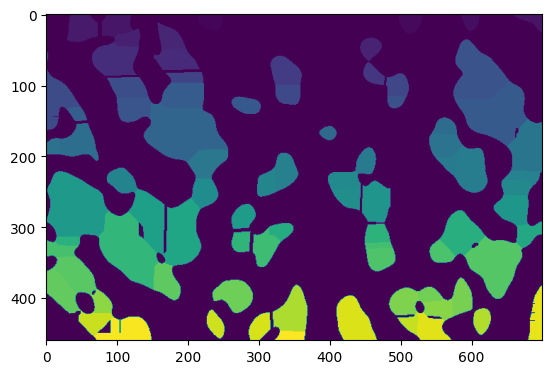

In [11]:
res, cell_population_density, nuclear_cytoplasmic_ratio = kmeans_watershed_nuclei_seg(img, sigma=7)
print(f'Mean cell population density: {round(cell_population_density, 2)}')
print(f'Nuclear VS cytoplasmic ratio: {round(nuclear_cytoplasmic_ratio, 2)}')
plt.imshow(res)
plt.show()

## Cell Property Calculation

## Tumor Diagnosis with Dense Convolutional Neural Network
### Model Training Pipeline
We used a DenseNet121 architecture pre-implemented
in the MONAI package (based on PyTorch) for breast tumor type classification.

#### Load Data & Labels

In [2]:
train_img, train_labels = load_data_labels(root_path="../data/train")
test_img, test_labels = load_data_labels(root_path="../data/test")

#### Set-up GPU/CPU for training

In [3]:
pinmemory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Construct Datasets

In [4]:
train_ds, train_loader = construct_datasets(images=train_img,
                                            labels=train_labels,
                                            batch_size=4,
                                            pinmemory=pinmemory)
test_ds, test_loader = construct_datasets(images=test_img,
                                          labels=test_labels,
                                          batch_size=4,
                                          pinmemory=pinmemory)

#### Initialize Model & Optimizer

In [5]:
model = monai.networks.nets.DenseNet121(spatial_dims=2, in_channels=3, out_channels=2).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

#### Training

In [6]:
model_train(max_epochs=1,
            model=model,
            optimizer=optimizer,
            train_loader=train_loader,
            train_ds=train_ds,
            writer=SummaryWriter(),
            device=device,
            loss_function=loss_function,
            val_interval=1,
            save_name="../models/best_metric_model_classification_DenseNet121.pth",
            test_loader=test_loader)

### Inference & Evaluation

#### Single Inference Example

In [8]:
prediction = model_inference(img_pth=test_img[0],
                             model_pth="../models/best_metric_model_classification_Dense121_9560.pth").cpu()
print(f'The prediction for {test_img[0]} is: {"malignant" if np.array(prediction)[0] else "benigh"}')

The prediction for ../data/test\benign\SOB_B_A-14-22549AB-400-001.png is: benigh


#### Model Evaluation

In [ ]:
# construct a new dataset of batch size 1 for inference
test_ds, test_loader = construct_datasets(images=test_img,
                                          labels=test_labels,
                                          batch_size=1,
                                          pinmemory=pinmemory)

# load pretrained model
model = load_trained_model(model_pth="../models/best_metric_model_classification_Dense121_9560.pth",
                           model_class=monai.networks.nets.DenseNet121,
                           device=device)
model.eval()

# test model accuracy on the whole dataset
wrong_images = []
wrong_labels = []
model.eval()
num_correct = 0.0
metric_count = 0
for val_data in test_loader:
    val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
    with torch.no_grad():
        val_outputs = model(val_images)
        value = torch.eq(val_outputs.argmax(dim=-1), val_labels)
        metric_count += len(value)
        num_correct += value.sum().item()
        if value.sum().item() != val_images.shape[0]:
            wrong_images.append(val_images)
            wrong_labels.append(val_labels)
metric = num_correct / metric_count
print(f'The model prediction accuracy on test dataset is: {round(metric*100, 2)}%')

## Graphical User Interface

